In [1]:
import sys
import os
import warnings
warnings.filterwarnings("ignore") # suppress the annpoying yfinance deprecation warnings

# Adding the root folder to sys path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from dataclasses import fields
from rich.console import Console
from rich.table import Table
from rich.pretty import pprint
from src.data.loaders import YFinanceLoader
from src.data.loaders import FamaFrenchLoader
from src.data.processing import DataProcessor
from src.data.metrics import FinancialMetrics
from src.index import IndexBuilder
from src.portfolio import PortfolioOptimizer
from src.config import AssignmentConfig
from src.plotting import PlottingUtil
from src.model import AssetPricingModel

In [3]:
console = Console()
default_config = AssignmentConfig()

#### Loading default configuration defined for this assignment from the dataclass

In [4]:
table = Table(title="Default Configuration")
table.add_column("Field", style="blue", no_wrap=True)
table.add_column("Value", style="green")

# Iterate over the fields of the dataclass and add them to the table
for f in fields(default_config):
    table.add_row(f.name, str(getattr(default_config, f.name)))

console.print(table)

                           Default Configuration                            
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Field                         ┃ Value                                    ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ trading_days                  │ 252                                      │
│ stock_list                    │ ['AAPL', 'MSFT', 'GOOGL', 'XOM', 'INTC'] │
│ benchmark_index               │ ^GSPC                                    │
│ risk_free_rate                │ 0.04                                     │
│ daily_adjusted_risk_free_rate │ 0.0001556498627912628                    │
│ start_date                    │ 2015-01-01                               │
│ end_date                      │ 2024-12-31                               │
└───────────────────────────────┴──────────────────────────────────────────┘

In [5]:
loader = YFinanceLoader()
df_olhcv = loader.get_daily_ohlcv(default_config.stock_list + [default_config.benchmark_index], 
                                  default_config.start_date, default_config.end_date)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [6]:
df_olhcv.Symbol.unique()

array(['AAPL', 'MSFT', 'GOOGL', 'XOM', 'INTC', '^GSPC'], dtype=object)

#### Just to show that they all have market cap >= 10 billion

In [7]:
loader.get_stock_info(default_config.stock_list ,["marketCap"])

,marketCap,Symbol
0,3791126003712,AAPL
1,3801767215104,MSFT
2,2985129672704,GOOGL
3,499737821184,XOM
4,165794299904,INTC


In [8]:
# We intend to do value weighted index, so we need shares outstanding
# to compute varying market cap at the daily level
outstanding_shares_df = loader.get_stock_info(default_config.stock_list ,["sharesOutstanding"])
outstanding_shares_df

,sharesOutstanding,Symbol
0,14840390000,AAPL
1,7433166379,MSFT
2,5817000000,GOOGL
3,4263247021,XOM
4,4670261514,INTC


Normalize by the first value of the sequence (normalize_method = "rebasing")

In [9]:
data_processor = DataProcessor(input_olhcv_data=df_olhcv, normalize_method="rebasing")
df_olhcv_processed = data_processor.process_data()

#### After normalization, when we groupby each symbol, the first value of `return` will always be `NaN` and the first `Close_normalized` will always be 1

In [10]:
df_olhcv_processed.groupby("Symbol").head(2)

,Date,Close,High,Low,Open,Volume,Symbol,Return,Close_normalized
0,2015-01-02,24.261049,24.729272,23.821673,24.718176,212818400,AAPL,NaN,1.000000
1,2015-01-05,23.577568,24.110144,23.391167,24.030258,257142000,AAPL,-0.028172,0.971828
2515,2015-01-02,26.296135,26.606494,26.213205,26.447589,26480000,GOOGL,NaN,1.000000
2516,2015-01-05,25.795088,26.218667,25.710175,26.176955,41182000,GOOGL,-0.019054,0.980946
5030,2015-01-02,27.896461,28.510244,27.704654,28.134301,23605600,INTC,NaN,1.000000
5031,2015-01-05,27.581902,27.965516,27.574228,27.773709,32785000,INTC,-0.011276,0.988724
7545,2015-01-02,39.933048,40.496688,39.745170,39.847650,27913900,MSFT,NaN,1.000000
7546,2015-01-05,39.565842,39.907440,39.497520,39.599999,39673900,MSFT,-0.009196,0.990804
10060,2015-01-02,58.423485,58.561945,57.781535,58.058455,10220400,XOM,NaN,1.000000
10061,2015-01-05,56.824924,58.152875,56.327729,57.964065,18502400,XOM,-0.027362,0.972638


#### Plotting normalized closing price

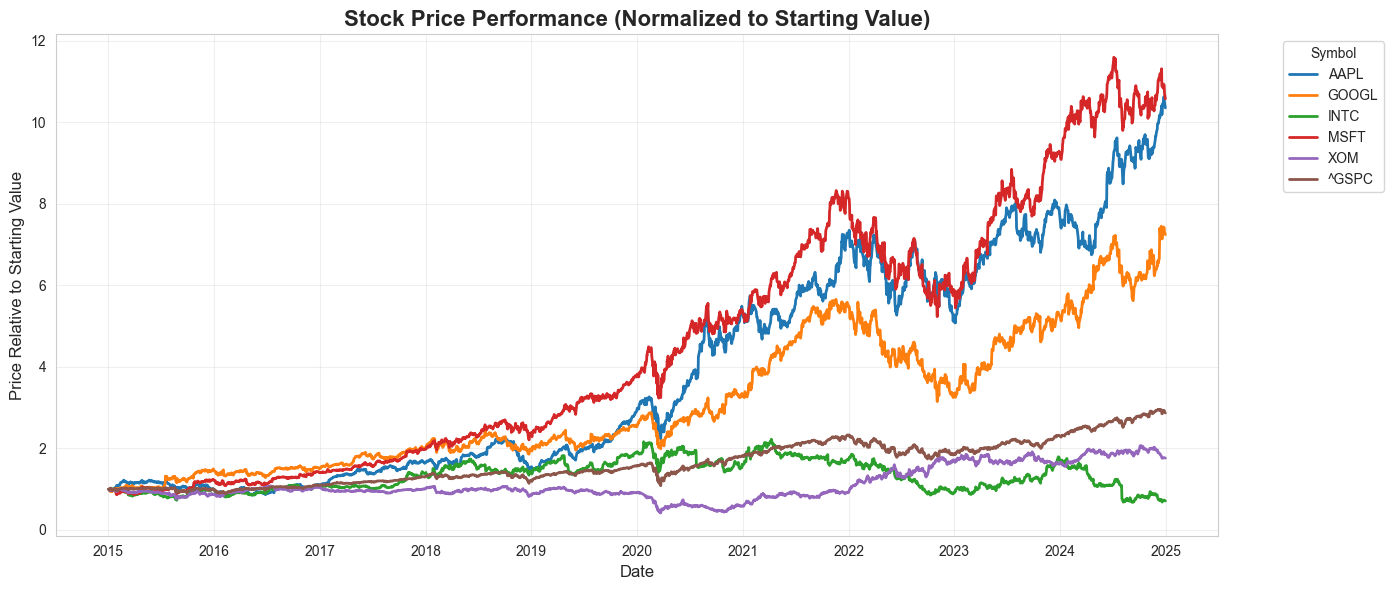

In [11]:
PlottingUtil.plot_stock_performance(df_olhcv_processed)

Annualized Return & Volatility

In [12]:
table = Table(title="Financial Metrics per Symbol")

table.add_column("Symbol", justify="right", style="blue", no_wrap=True)
table.add_column("Annualized Return (Arithmetic)", justify="right", style="purple")
table.add_column("Annualized Return (Geometric)", justify="right", style="green")
table.add_column("Annualized Volatility", justify="right", style="yellow")

for symbol in df_olhcv_processed['Symbol'].unique():
    df_symbol = df_olhcv_processed.loc[df_olhcv_processed['Symbol'] == symbol, "Close_normalized"].pct_change().dropna()
    
    financial_metrics = FinancialMetrics(df_symbol)
    annualized_return_arith = financial_metrics.annualized_return(method="arithmetic")
    annualized_return_geom = financial_metrics.annualized_return(method="geometric")
    annualized_volatility = financial_metrics.annualized_volatility()
    
    # Add a row to the table for each symbol
    table.add_row(
        symbol,
        f"{annualized_return_arith:.2%}",
        f"{annualized_return_geom:.2%}",
        f"{annualized_volatility:.2%}"
    )

console.print(table)

                                   Financial Metrics per Symbol                                    
┏━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Symbol ┃ Annualized Return (Arithmetic) ┃ Annualized Return (Geometric) ┃ Annualized Volatility ┃
┡━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│   AAPL │                         27.50% │                        26.41% │                28.46% │
│  GOOGL │                         23.91% │                        21.96% │                28.47% │
│   INTC │                          3.04% │                        -3.37% │                35.66% │
│   MSFT │                         27.34% │                        26.68% │                27.14% │
│    XOM │                          9.53% │                         5.84% │                27.78% │
│  ^GSPC │                         12.17% │                        11.15% │                17.83% │
└────────┴────────────────────────────────┴───────────────────────────────┴───────────────────────┘

In [13]:
df_exclude_sp = df_olhcv_processed.loc[df_olhcv_processed['Symbol'] != '^GSPC'].reset_index(drop=True)

index_builder = IndexBuilder(input_data=df_exclude_sp, shares_outstanding_data=outstanding_shares_df)
df_equal_weighted_index = index_builder.build_equal_weighted_index(base_value=1.0) # base value is an optional parameter
df_price_weighted_index = index_builder.build_price_weighted_index()
df_value_weighted_index = index_builder.build_value_weighted_index(base_value=1.0)
df_value_risk_parity_index = index_builder.build_risk_parity_index(base_value=1.0, rolling_window=252)

In [14]:
df_equal_weighted_index.head()

,Date,Equal_Weighted_Index
0,2015-01-02,NaN
1,2015-01-05,0.980988
2,2015-01-06,0.968585
3,2015-01-07,0.979219
4,2015-01-08,1.000090


In [15]:
df_price_weighted_index.head()

,Date,Price_Weighted_Index
0,2015-01-02,1.000000
1,2015-01-05,0.980988
2,2015-01-06,0.968537
3,2015-01-07,0.979211
4,2015-01-08,1.000205


In [16]:
df_value_weighted_index.head()

,Date,Value_Weighted_Index
0,2015-01-02,1.000000
1,2015-01-05,0.979829
2,2015-01-06,0.970086
3,2015-01-07,0.981268
4,2015-01-08,1.005981


In [17]:
df_value_risk_parity_index.head()

,Date,Risk_Parity_Index
0,2015-01-02,1.000000
1,2015-01-05,1.000000
2,2015-01-06,0.982950
3,2015-01-07,0.991988
4,2015-01-08,1.010453


In [18]:
index_df_combined = (
    df_equal_weighted_index.merge(
        df_price_weighted_index, on="Date", how="inner"
    )
    .merge(
        df_value_weighted_index, on="Date", how="inner"
    )
    .merge(
        df_value_risk_parity_index, on="Date", how="inner"
    )
    .merge(
        df_olhcv_processed.loc[df_olhcv_processed['Symbol'] == '^GSPC', ['Date', 'Close_normalized']],
        on="Date",
        how="inner"
    )
    .rename(columns={"Close_normalized": "SP_500"})
    .dropna()
    .reset_index(drop=True)
)

In [19]:
index_df_combined.head()

,Date,Equal_Weighted_Index,Price_Weighted_Index,Value_Weighted_Index,Risk_Parity_Index,SP_500
0,2015-01-05,0.980988,0.980988,0.979829,1.000000,0.981722
1,2015-01-06,0.968585,0.968537,0.970086,0.982950,0.972991
2,2015-01-07,0.979219,0.979211,0.981268,0.991988,0.984307
3,2015-01-08,1.000090,1.000205,1.005981,1.010453,1.001914
4,2015-01-09,0.996281,0.996481,1.002617,1.005552,0.993494


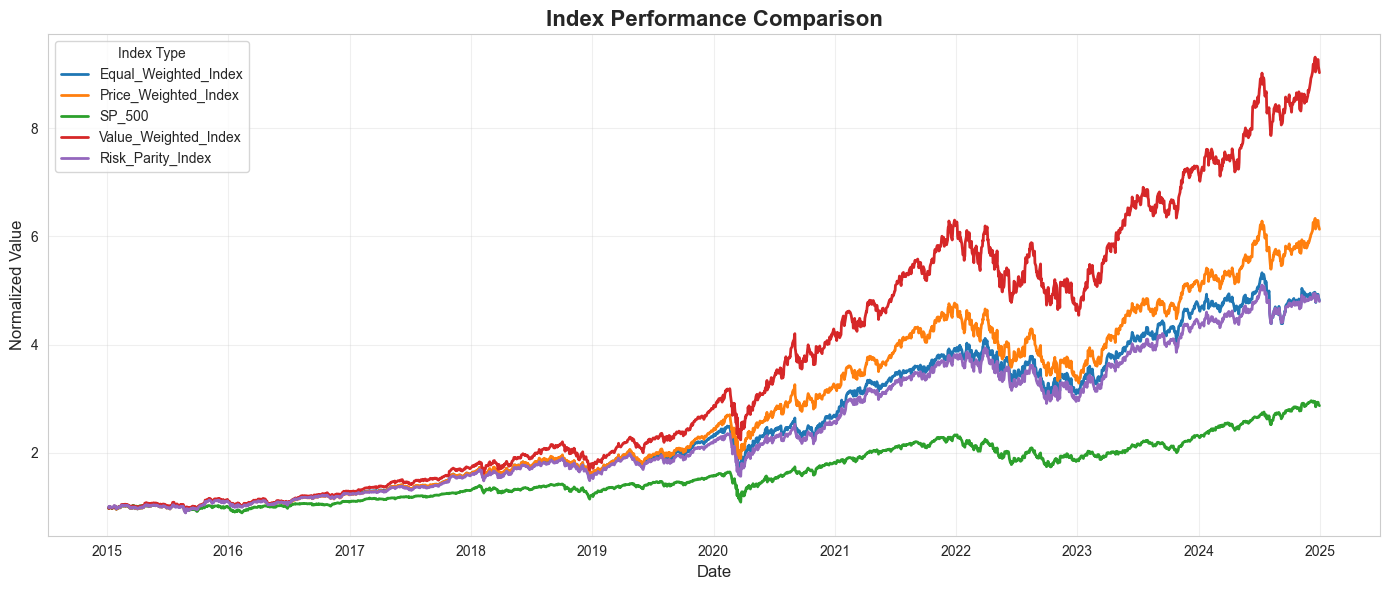

In [20]:
PlottingUtil.plot_index_performance(index_df_combined)

In [21]:

table = Table(title="Annualized Financial Metrics for the Indexes")

table.add_column("Index", justify="right", style="blue", no_wrap=True)
table.add_column("Annualized Return (Arithmetic)", justify="right", style="purple")
table.add_column("Annualized Return (Geometric)", justify="right", style="green")
table.add_column("Annualized Volatility", justify="right", style="yellow")


for col in [i for i in index_df_combined.columns if i != "Date"]:
    series = index_df_combined[col].pct_change().dropna()
    financial_metrics = FinancialMetrics(series)
    
    annualized_return_arith = financial_metrics.annualized_return(method="arithmetic")
    annualized_return_geom = financial_metrics.annualized_return(method="geometric")
    annualized_volatility = financial_metrics.annualized_volatility()
    
    table.add_row(
        col,
        f"{annualized_return_arith:.2%}",
        f"{annualized_return_geom:.2%}",
        f"{annualized_volatility:.2%}"
    )

console.print(table)


                                  Annualized Financial Metrics for the Indexes                                   
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃                Index ┃ Annualized Return (Arithmetic) ┃ Annualized Return (Geometric) ┃ Annualized Volatility ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Equal_Weighted_Index │                         18.46% │                        17.30% │                22.33% │
│ Price_Weighted_Index │                         21.08% │                        20.18% │                23.19% │
│ Value_Weighted_Index │                         25.03% │                        24.94% │                23.44% │
│    Risk_Parity_Index │                         18.13% │                        17.03% │                21.87% │
│               SP_500 │                         12.35% │                        11.36% │                17.82% │
└──────────────────────┴────────────────────────────────┴───────────────────────────────┴───────────────────────┘

#### Market Portfolio A:
Portfolio constructed using the 3 stocks that come from the same sector and have positive returns for the past 10 years

In [22]:
df_portfolio_a = df_olhcv_processed.loc[df_olhcv_processed['Symbol'].isin(['AAPL', 'GOOGL', 'MSFT'])]

In [23]:
portfolio_optimizer = PortfolioOptimizer(input_data=df_portfolio_a, 
                                         risk_free_rate=default_config.risk_free_rate, 
                                         iterations=10000)
# We are using the arithmetic annualized return for the calculation here for simplicity

results, max_sharpe_portfolio, min_volatility_portfolio = portfolio_optimizer.monte_carlo_optimization()

In [24]:
results.head()

,Return,Volatility,Sharpe Ratio,Weight_AAPL,Weight_GOOGL,Weight_MSFT
0,0.257807,0.249964,0.871355,0.182059,0.462129,0.355812
1,0.268537,0.256248,0.891858,0.657381,0.171323,0.171296
2,0.253952,0.256982,0.832558,0.038078,0.567845,0.394077
3,0.273622,0.253944,0.919973,0.416865,0.012119,0.571017
4,0.268509,0.257438,0.887627,0.678655,0.173111,0.148234


In [25]:
console.print("[bold blue]Maximum Sharpe Ratio Portfolio:[/bold blue]")
table = Table(show_header=True)
table.add_column("Metric", style="green")
table.add_column("Value", style="yellow")

for key, value in max_sharpe_portfolio.items():
    table.add_row(key, f"{value:.6f}" if isinstance(value, float) else str(value))

console.print(table)

Maximum Sharpe Ratio Portfolio:

┏━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Metric       ┃ Value    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│ Return       │ 0.271562 │
│ Volatility   │ 0.251418 │
│ Sharpe Ratio │ 0.921023 │
│ Weight_AAPL  │ 0.412504 │
│ Weight_GOOGL │ 0.071934 │
│ Weight_MSFT  │ 0.515562 │
└──────────────┴──────────┘

In [26]:
console.print("[bold blue]Minimum Volatility Portfolio:[/bold blue]")
table = Table(show_header=True)
table.add_column("Metric", style="green")
table.add_column("Value", style="yellow")

for key, value in min_volatility_portfolio.items():
    table.add_row(key, f"{value:.6f}" if isinstance(value, float) else str(value))

console.print(table)

Minimum Volatility Portfolio:

┏━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Metric       ┃ Value    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│ Return       │ 0.263300 │
│ Volatility   │ 0.246924 │
│ Sharpe Ratio │ 0.904327 │
│ Weight_AAPL  │ 0.332790 │
│ Weight_GOOGL │ 0.308997 │
│ Weight_MSFT  │ 0.358212 │
└──────────────┴──────────┘

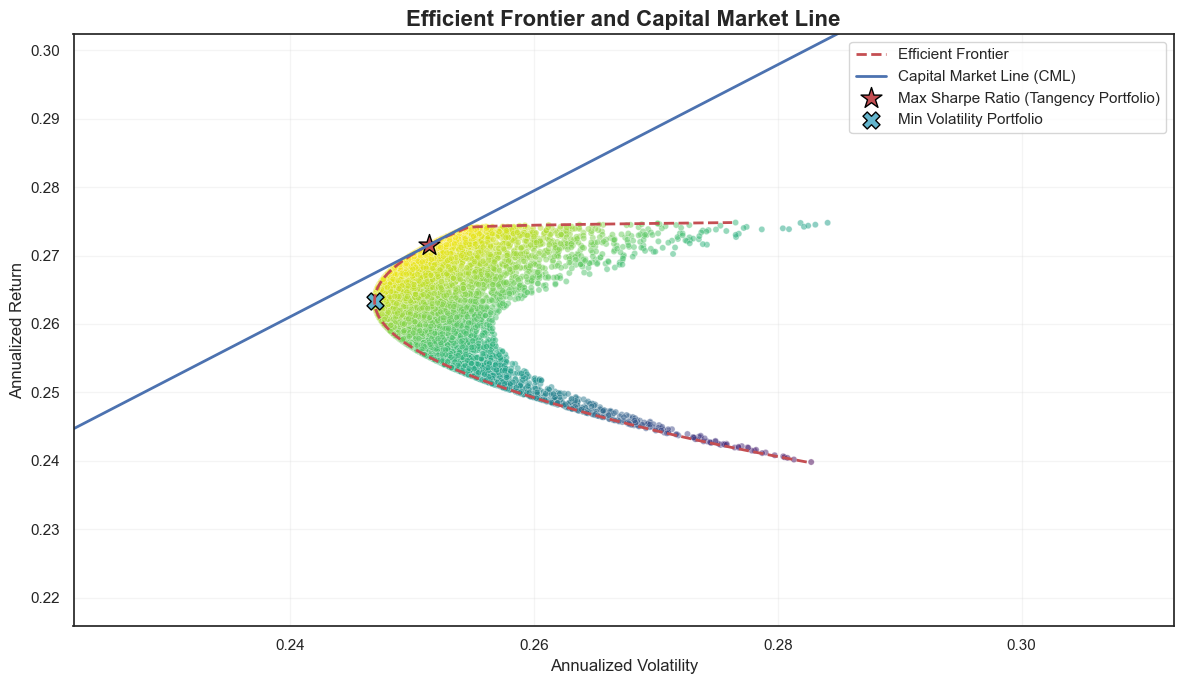

In [27]:
efficient_frontier = portfolio_optimizer.calculate_efficient_frontier(results, 1000)

cml_x, cml_y = portfolio_optimizer.calculate_cml(max_sharpe_portfolio, results)

PlottingUtil.plot_portfolio_optimization_results(results, 
                                                 efficient_frontier, 
                                                 cml_x, 
                                                 cml_y, 
                                                 max_sharpe_portfolio, 
                                                 min_volatility_portfolio)

In [28]:
optimal_weights = max_sharpe_portfolio.filter(like="Weight_")

portfolio_return = pd.Series(
    np.dot(portfolio_optimizer.returns, optimal_weights), 
)

market_return = df_olhcv_processed.loc[df_olhcv_processed['Symbol'] == '^GSPC',"Return"].dropna().reset_index(drop=True)

In [29]:
df_returns = pd.DataFrame({
    "Portfolio_Return": portfolio_return,
    "Market_Return": market_return
})

df_returns['Portfolio_Excess_Return'] = df_returns['Portfolio_Return'] - default_config.risk_free_rate
df_returns['Market_Excess_Return'] = df_returns['Market_Return'] - default_config.risk_free_rate    

In [30]:
pricing_model = AssetPricingModel(df_returns)

In [51]:
capm_results = pricing_model.fit_capm_model()
pprint(capm_results)

{
│   'beta': 1.1914714006797282,
│   'alpha': 0.0005113968759391436,
│   'annualized_alpha': 0.12887201273666418,
│   'r_squared': np.float64(0.7379201960659529),
│   'p_value_alpha': np.float64(0.0013302463786586413),
│   'p_value_beta': np.float64(0.0),
│   'std_err_alpha': np.float64(0.0001591655928639486),
│   'std_err_beta': np.float64(0.014167260645119455)
}

In [39]:
ff_loader = FamaFrenchLoader(start = "2015-01-05", end = "2024-12-30")
df_ff_factors = ff_loader.get_ff_momentum_factor()

In [40]:
df_ff_factors.head()

,Date,Mkt-RF,SMB,HML,RF,MOM
0,2015-01-05,-1.84,0.33,-0.67,0.0,1.14
1,2015-01-06,-1.03,-0.79,-0.29,0.0,0.49
2,2015-01-07,1.19,0.20,-0.67,0.0,0.89
3,2015-01-08,1.81,-0.11,-0.29,0.0,0.14
4,2015-01-09,-0.85,0.00,-0.47,0.0,-0.01


In [42]:
ff3_results = pricing_model.fit_fama_french_3f_model(df_ff_factors)
pprint(ff3_results)

{
│   'betas': Mkt-RF    0.011846
SMB      -0.003697
HML      -0.004338
dtype: float64,
│   'alpha': np.float64(-0.039560655368986924),
│   'annualized_alpha': np.float64(-9.969285152984705),
│   'r_squared': np.float64(0.7961718618777611),
│   'p_value_alpha': np.float64(0.0),
│   'p_value_beta': np.float64(0.0),
│   'std_err_alpha': np.float64(0.00014284849061588288),
│   'std_err_beta': np.float64(0.00012720547519438091)
}

In [43]:
c4_results = pricing_model.fit_carhart_4f_model(df_ff_factors)
pprint(c4_results)

{
│   'betas': Mkt-RF    0.011916
SMB      -0.003508
HML      -0.004106
MOM       0.000580
dtype: float64,
│   'alpha': np.float64(-0.0395672046057543),
│   'annualized_alpha': np.float64(-9.970935560650084),
│   'r_squared': np.float64(0.7975443535987284),
│   'p_value_alpha': np.float64(0.0),
│   'p_value_beta': np.float64(0.0),
│   'std_err_alpha': np.float64(0.00014240396072091586),
│   'std_err_beta': np.float64(0.00012792556772239894)
}

#### Market Portfolio B:
Using all 5 stocks

In [44]:
df_all_stocks = df_olhcv_processed.loc[df_olhcv_processed['Symbol'].isin(default_config.stock_list)]

In [45]:
portfolio_optimizer = PortfolioOptimizer(input_data=df_all_stocks, risk_free_rate=default_config.risk_free_rate, iterations=10000)

results, max_sharpe_portfolio, min_volatility_portfolio = portfolio_optimizer.monte_carlo_optimization()

In [46]:
results.head()

,Return,Volatility,Sharpe Ratio,Weight_AAPL,Weight_GOOGL,Weight_INTC,Weight_MSFT,Weight_XOM
0,0.188853,0.241233,0.617050,0.133197,0.338101,0.260318,0.212900,0.055485
1,0.131806,0.234542,0.391428,0.065285,0.024308,0.362501,0.251571,0.296334
2,0.152545,0.250892,0.448580,0.009284,0.437468,0.375464,0.095773,0.082010
3,0.164187,0.232885,0.533256,0.105673,0.175297,0.302353,0.248877,0.167800
4,0.189771,0.221407,0.676454,0.327909,0.074759,0.156568,0.196343,0.244421


In [47]:
optimal_weights = max_sharpe_portfolio.filter(like="Weight_")
portfolio_return = pd.Series(
    np.dot(portfolio_optimizer.returns, optimal_weights), 
)

df_returns = pd.DataFrame({
    "Portfolio_Return": portfolio_return,
    "Market_Return": market_return
})

df_returns['Portfolio_Excess_Return'] = df_returns['Portfolio_Return'] - default_config.daily_adjusted_risk_free_rate
df_returns['Market_Excess_Return'] = df_returns['Market_Return'] - default_config.daily_adjusted_risk_free_rate

In [53]:
pricing_model = AssetPricingModel(df_returns)

# CAPM Model
console.print("[bold blue]CAPM Model:[/bold blue]")
capm_results = pricing_model.fit_capm_model()
pprint(capm_results)

# Fama-French 3-Factor Model
console.print("\n[bold blue]Fama-French 3-Factor Model:[/bold blue]")
ff3_results = pricing_model.fit_fama_french_3f_model(df_ff_factors)
pprint(ff3_results)

# Carhart 4-Factor Model
console.print("\n[bold blue]Carhart 4-Factor Model:[/bold blue]")
c4_results = pricing_model.fit_carhart_4f_model(df_ff_factors)
pprint(c4_results)

CAPM Model:

{
│   'beta': 1.1914714006797282,
│   'alpha': 0.0005113968759391436,
│   'annualized_alpha': 0.12887201273666418,
│   'r_squared': np.float64(0.7379201960659529),
│   'p_value_alpha': np.float64(0.0013302463786586413),
│   'p_value_beta': np.float64(0.0),
│   'std_err_alpha': np.float64(0.0001591655928639486),
│   'std_err_beta': np.float64(0.014167260645119455)
}

Fama-French 3-Factor Model:

{
│   'betas': Mkt-RF    0.011742
SMB      -0.003477
HML      -0.004199
dtype: float64,
│   'alpha': np.float64(0.0002705929370086849),
│   'annualized_alpha': np.float64(0.06818942012618859),
│   'r_squared': np.float64(0.8054399077980401),
│   'p_value_alpha': np.float64(0.04882743334483994),
│   'p_value_beta': np.float64(0.0),
│   'std_err_alpha': np.float64(0.00013728338987708028),
│   'std_err_beta': np.float64(0.00012224979606237284)
}

Carhart 4-Factor Model:

{
│   'betas': Mkt-RF    0.011795
SMB      -0.003333
HML      -0.004022
MOM       0.000443
dtype: float64,
│   'alpha': np.float64(0.0002655931859173936),
│   'annualized_alpha': np.float64(0.06692948285118319),
│   'r_squared': np.float64(0.8062665737817284),
│   'p_value_alpha': np.float64(0.05270465784493043),
│   'p_value_beta': np.float64(0.0),
│   'std_err_alpha': np.float64(0.0001370272452930908),
│   'std_err_beta': np.float64(0.00012309550983563626)
}

#### Individual stocks vs Market (doing this due to ambiguity of the qn)

In [54]:
for s in df_exclude_sp["Symbol"].unique():
    df_single_stock_return = (
        df_exclude_sp.loc[df_exclude_sp['Symbol'] == s,"Return"].dropna())
    df_returns = pd.DataFrame({
        f"{s}_Return": df_single_stock_return.reset_index(drop=True),
        "Market_Return": market_return
    })
    
    df_returns['Portfolio_Excess_Return'] = df_returns[f"{s}_Return"] - default_config.risk_free_rate
    df_returns['Market_Excess_Return'] = df_returns['Market_Return'] - default_config.risk_free_rate
    pricing_model = AssetPricingModel(df_returns)
    
    console.print(f"[bold blue]Results for {s}:[/bold blue]")
    
    # CAPM Model
    console.print("[bold green]CAPM Model:[/bold green]")
    capm_results = pricing_model.fit_capm_model()
    pprint(capm_results)
    
    # Fama-French 3-Factor Model
    console.print("\n[bold green]Fama-French 3-Factor Model:[/bold green]")
    ff3_results = pricing_model.fit_fama_french_3f_model(df_ff_factors)
    pprint(ff3_results)
    
    # Carhart 4-Factor Model
    console.print("\n[bold green]Carhart 4-Factor Model:[/bold green]")
    c4_results = pricing_model.fit_carhart_4f_model(df_ff_factors)
    pprint(c4_results)
    
    console.print("\n" + "-" * 80 + "\n")

Results for AAPL:

CAPM Model:

{
│   'beta': 1.192473319363171,
│   'alpha': 0.008214300048463352,
│   'annualized_alpha': 2.0700036122127647,
│   'r_squared': np.float64(0.5579155985859906),
│   'p_value_alpha': np.float64(8.142235175998896e-21),
│   'p_value_beta': np.float64(0.0),
│   'std_err_alpha': np.float64(0.0008700767764653291),
│   'std_err_beta': np.float64(0.021179085181827654)
}

Fama-French 3-Factor Model:

{
│   'betas': Mkt-RF    0.011714
SMB      -0.003011
HML      -0.003999
dtype: float64,
│   'alpha': np.float64(-0.03953346670279467),
│   'annualized_alpha': np.float64(-9.962433609104258),
│   'r_squared': np.float64(0.6015178482338086),
│   'p_value_alpha': np.float64(0.0),
│   'p_value_beta': np.float64(0.0),
│   'std_err_alpha': np.float64(0.00022614190414033822),
│   'std_err_beta': np.float64(0.00020137761521671552)
}

Carhart 4-Factor Model:

{
│   'betas': Mkt-RF    0.011774
SMB      -0.002849
HML      -0.003800
MOM       0.000497
dtype: float64,
│   'alpha': np.float64(-0.0395390792985337),
│   'annualized_alpha': np.float64(-9.963847983230494),
│   'r_squared': np.float64(0.6023041510554454),
│   'p_value_alpha': np.float64(0.0),
│   'p_value_beta': np.float64(0.0),
│   'std_err_alpha': np.float64(0.00022597774543085876),
│   'std_err_beta': np.float64(0.00020300229874592514)
}

--------------------------------------------------------------------------------

Results for GOOGL:

CAPM Model:

{
│   'beta': 1.1478408627776733,
│   'alpha': 0.006308107635142153,
│   'annualized_alpha': 1.5896431240558224,
│   'r_squared': np.float64(0.5166663846092912),
│   'p_value_alpha': np.float64(5.2554080899731495e-12),
│   'p_value_beta': np.float64(0.0),
│   'std_err_alpha': np.float64(0.0009099984257544473),
│   'std_err_beta': np.float64(0.022150843116027587)
}

Fama-French 3-Factor Model:

{
│   'betas': Mkt-RF    0.011251
SMB      -0.002590
HML      -0.004145
dtype: float64,
│   'alpha': np.float64(-0.039652526507736444),
│   'annualized_alpha': np.float64(-9.992436679949584),
│   'r_squared': np.float64(0.563322807560038),
│   'p_value_alpha': np.float64(0.0),
│   'p_value_beta': np.float64(0.0),
│   'std_err_alpha': np.float64(0.00023679308833911161),
│   'std_err_beta': np.float64(0.00021086241230169927)
}

Carhart 4-Factor Model:

{
│   'betas': Mkt-RF    0.011207
SMB      -0.002709
HML      -0.004291
MOM      -0.000366
dtype: float64,
│   'alpha': np.float64(-0.03964839909352096),
│   'annualized_alpha': np.float64(-9.991396571567282),
│   'r_squared': np.float64(0.5637478126215167),
│   'p_value_alpha': np.float64(0.0),
│   'p_value_beta': np.float64(0.0),
│   'std_err_alpha': np.float64(0.0002367397096056347),
│   'std_err_beta': np.float64(0.00021267008024509603)
}

--------------------------------------------------------------------------------

Results for INTC:

CAPM Model:

{
│   'beta': 1.2605445495155354,
│   'alpha': 0.009933765905118522,
│   'annualized_alpha': 2.5033090080898677,
│   'r_squared': np.float64(0.3971149140403436),
│   'p_value_alpha': np.float64(8.802497548791725e-15),
│   'p_value_beta': np.float64(2.3809481723505652e-278),
│   'std_err_alpha': np.float64(0.0012730865578486068),
│   'std_err_beta': np.float64(0.030988999341013693)
}

Fama-French 3-Factor Model:

{
│   'betas': Mkt-RF    0.012350
SMB      -0.000879
HML      -0.001062
dtype: float64,
│   'alpha': np.float64(-0.04049328663871216),
│   'annualized_alpha': np.float64(-10.204308232955466),
│   'r_squared': np.float64(0.3989430453104956),
│   'p_value_alpha': np.float64(0.0),
│   'p_value_beta': np.float64(1.52532323251664e-269),
│   'std_err_alpha': np.float64(0.00034799267478336193),
│   'std_err_beta': np.float64(0.0003098847833052242)
}

Carhart 4-Factor Model:

{
│   'betas': Mkt-RF    0.012358
SMB      -0.000857
HML      -0.001034
MOM       0.000068
dtype: float64,
│   'alpha': np.float64(-0.04049405401264747),
│   'annualized_alpha': np.float64(-10.204501611187162),
│   'r_squared': np.float64(0.39895240809515886),
│   'p_value_alpha': np.float64(0.0),
│   'p_value_beta': np.float64(5.228169535522062e-266),
│   'std_err_alpha': np.float64(0.00034808094897903095),
│   'std_err_beta': np.float64(0.00031269111326728507)
}

--------------------------------------------------------------------------------

Results for MSFT:

CAPM Model:

{
│   'beta': 1.2149943552669922,
│   'alpha': 0.009098017761225367,
│   'annualized_alpha': 2.2927004758287928,
│   'r_squared': np.float64(0.6370393310549978),
│   'p_value_alpha': np.float64(8.204541590309994e-33),
│   'p_value_beta': np.float64(0.0),
│   'std_err_alpha': np.float64(0.0007517293078860815),
│   'std_err_beta': np.float64(0.0182983151326877)
}

Fama-French 3-Factor Model:

{
│   'betas': Mkt-RF    0.012035
SMB      -0.004400
HML      -0.004636
dtype: float64,
│   'alpha': np.float64(-0.03956959071149898),
│   'annualized_alpha': np.float64(-9.971536859297743),
│   'r_squared': np.float64(0.7113619026999942),
│   'p_value_alpha': np.float64(0.0),
│   'p_value_beta': np.float64(0.0),
│   'std_err_alpha': np.float64(0.00018351862736628587),
│   'std_err_beta': np.float64(0.000163421917169024)
}

Carhart 4-Factor Model:

{
│   'betas': Mkt-RF    0.012128
SMB      -0.004147
HML      -0.004325
MOM       0.000779
dtype: float64,
│   'alpha': np.float64(-0.03957837903336543),
│   'annualized_alpha': np.float64(-9.97375151640809),
│   'r_squared': np.float64(0.7134823172820537),
│   'p_value_alpha': np.float64(0.0),
│   'p_value_beta': np.float64(0.0),
│   'std_err_alpha': np.float64(0.00018289110146530997),
│   'std_err_beta': np.float64(0.0001642963290338332)
}

--------------------------------------------------------------------------------

Results for XOM:

CAPM Model:

{
│   'beta': 0.8550298706585469,
│   'alpha': -0.005833251455782049,
│   'annualized_alpha': -1.4699793668570762,
│   'r_squared': np.float64(0.3010123521299136),
│   'p_value_alpha': np.float64(5.1724801503436164e-08),
│   'p_value_beta': np.float64(1.3058345072550952e-197),
│   'std_err_alpha': np.float64(0.0010679832499969205),
│   'std_err_beta': np.float64(0.02599645092969705)
}

Fama-French 3-Factor Model:

{
│   'betas': Mkt-RF    0.008789
SMB      -0.000687
HML       0.009048
dtype: float64,
│   'alpha': np.float64(-0.0399612092945906),
│   'annualized_alpha': np.float64(-10.070224742236832),
│   'r_squared': np.float64(0.5121773724182557),
│   'p_value_alpha': np.float64(0.0),
│   'p_value_beta': np.float64(1.8836986359257556e-275),
│   'std_err_alpha': np.float64(0.00024424871518098103),
│   'std_err_beta': np.float64(0.00021750159029513148)
}

Carhart 4-Factor Model:

{
│   'betas': Mkt-RF    0.008655
SMB      -0.001050
HML       0.008602
MOM      -0.001117
dtype: float64,
│   'alpha': np.float64(-0.03994860262353037),
│   'annualized_alpha': np.float64(-10.067047861129653),
│   'r_squared': np.float64(0.5163404426040503),
│   'p_value_alpha': np.float64(0.0),
│   'p_value_beta': np.float64(7.0701046518879505e-267),
│   'std_err_alpha': np.float64(0.00024326786244090222),
│   'std_err_beta': np.float64(0.000218534507423964)
}

--------------------------------------------------------------------------------